In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

%cd /content/drive/MyDrive/Colab\ Notebooks/workhuman/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/workhuman
/content/drive/MyDrive/Colab Notebooks/workhuman


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU available")
    # Restrict TensorFlow to use only the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

GPU available
1 Physical GPU, 1 Logical GPU


In [4]:
# Explicitly set TensorFlow to use GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
# Ensure TensorFlow uses the GPU
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("TensorFlow is using the GPU")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [5]:
# Check GPU usage during TensorFlow operations
tf.debugging.set_log_device_placement(True)

with tf.device('/GPU:0'):
    # Example TensorFlow operations
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
    b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
    c = tf.multiply(a, b)
    print(c)

tf.Tensor([5. 8. 9. 8. 5.], shape=(5,), dtype=float32)


In [6]:
# Check device placement for TensorFlow operations
with tf.device('/GPU:0'):
    # Example TensorFlow operations
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
    b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
    c = tf.multiply(a, b)
    print(c)

tf.Tensor([5. 8. 9. 8. 5.], shape=(5,), dtype=float32)


In [56]:
#!pip install sentence-transformers
#from sentence_transformers import SentenceTransformer
#!pip install joblib

In [62]:
# import requried packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(leave=False)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support

import xgboost as xgb
from imblearn.pipeline import Pipeline

import joblib
from joblib import dump, load
# Assuming grid_search is your GridSearchCV instance

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##**Load Data**

In [9]:
# setting random seed

seed = 42
np.random.seed(seed)
#random.seed(seed)

Anchor: check explaination why both are to be set above

In [10]:
# loading data

df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/workhuman/data.csv")
df.sample(10)

,text,target
677,Thankyou for helping read the results for the ...,False
1591,Congratulations on your remarkable achievement...,False
984,This is in recognition of the amazing job you ...,False
607,"Allison, I want to thank and recognize for all...",False
1392,"John, I want to thank you for the incredible ...",False
1033,"Guys ,everyone showed their metal today in exc...",False
1583,Your kindness does not go unnoticed and I want...,False
1309,"Margarita, I couldn't think of a better exampl...",False
1628,Thanks so much for all of the support as of la...,False
271,Congratulations on your recent work anniversar...,False


In [11]:
# check shape of data
df.shape, df['text'].nunique()

((1638, 2), 1638)

In [12]:
df['target'] = df['target'].map({False: 0, True: 1})

In [13]:
df["target"].value_counts()

target
0    1393
1     245
Name: count, dtype: int64



*   Based on the observations so far, there is unbalance in the target variables.
* Current step: Sampling techniques
  * upsampling minor class to match major class
  * Issues with this process: duplicating both major and minor classes which is not a good sampling strategy as it causes various problems including overfitting by introducing noise, since major classes are also duplicated there is also loss of information, thereby not generalizing the model thus resulting in poor performance on unseen data
* Proposed changes:
  * Perform data cleaning
  * Use different sampling techniques



##**Data Preprocessing**

**Step 1: Tokenization**

In [14]:
def clean_text(text):
    # Remove unwanted characters (punctuation, numbers, special characters)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization with POS tagging
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    # Rejoin words into a single string
    text = ' '.join(lemmatized_words)

    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun for lemmatization

In [15]:
# Apply the clean on df

df ['clean_text'] = df['text'].apply(clean_text)

In [16]:
# check for any missing values

print(df.isnull().sum())

print(df[['text', 'clean_text']].head())

text          0
target        0
clean_text    0
dtype: int64
                                                text  \
0  Thank you for quickly producing high quality p...   
1  Thank you for working safely and thank you for...   
2  Well done! Finding a potential trip hazard and...   
3  Thank you for the leadership you continue to p...   
4  Rakesh Lakshmanan worked closely with Cisco & ...   

                                          clean_text  
0  thank quickly produce high quality part smart ...  
1  thank work safely thank complete pit preinspec...  
2  well do find potential trip hazard come soluti...  
3  thank leadership continue provide ensure hazar...  
4  rakesh lakshmanan work closely cisco aruba ven...  


In [17]:
df.head()

,text,target,clean_text
0,Thank you for quickly producing high quality p...,1,thank quickly produce high quality part smart ...
1,Thank you for working safely and thank you for...,1,thank work safely thank complete pit preinspec...
2,Well done! Finding a potential trip hazard and...,1,well do find potential trip hazard come soluti...
3,Thank you for the leadership you continue to p...,1,thank leadership continue provide ensure hazar...
4,Rakesh Lakshmanan worked closely with Cisco & ...,1,rakesh lakshmanan work closely cisco aruba ven...


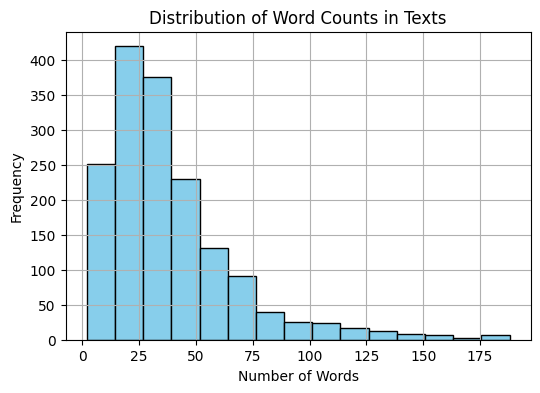

In [18]:
# Function to calculate number of words
def count_words(text):
    return len(text.split())

# Add new column for word count
df['word_count'] = df['clean_text'].apply(count_words)

# Visualize word count distribution as a histogram
plt.figure(figsize=(6, 4))
plt.hist(df['word_count'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Texts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,1638.0,0.149573,0.356761,0.0,0.0,0.0,0.0,1.0
word_count,1638.0,38.528694,29.098343,2.0,19.0,32.0,49.0,188.0


In [20]:
# Define upper and lower cutoffs based on descriptive statistics
lower_cutoff = 15  # Example lower cutoff
upper_cutoff = 50  # Example upper cutoff

# Apply lower and upper cutoffs
df = df[(df['word_count'] >= lower_cutoff) & (df['word_count'] <= upper_cutoff)]

# Optionally, truncate texts to upper cutoff length
df['truncated_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()[:upper_cutoff]))

<ipython-input-20-076df8263dd0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['truncated_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()[:upper_cutoff]))


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,1005.0,0.183085,0.386928,0.0,0.0,0.0,0.0,1.0
word_count,1005.0,30.234826,9.812819,15.0,22.0,29.0,38.0,50.0


**Step 2: Train test validation split**

In [22]:
X = df['truncated_text']
y = df['target']

In [23]:
# Initial split into train and validate
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondary split train into new train and test
#X_train_new, X_test, y_train_new, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

**Step 3: Embeddings**

In [24]:
# You can use the embeddings provided - they were produced with these next cells that are commented out
# Or feel free to adapt as you'd like/create new embeddings

# model = SentenceTransformer("paraphrase-mpnet-base-v2")

# train_embs = []
# for text in tqdm(X_train):
#     emb = model.encode(text)
#     train_embs.append(emb)
# X_train_embeddings = np.array(train_embs)

# val_embs = []
# for text in tqdm(X_val):
#     emb = model.encode(text)
#     val_embs.append(emb)
# X_val_embeddings = np.array(val_embs)

# np.save('train_embs2.npy', train_embs)
# np.save('val_embs2.npy', val_embs)

In [25]:
X_train_embs = np.load('train_embs2.npy')
X_val_embs = np.load('val_embs2.npy')

In [26]:
# print(X_train_embs.shape)
# print(X_train_embs)

In [27]:
# print(X_val_embs.shape)
# print(X_val_embs)

Anchor:
Add current vs proposed changes

**Step 4: Sampling techniques**

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embs, y_train)

**Step 5.1: LR Modelling with CV**

Anchor:
Add current vs proposed changes to modelling

Achor: use seed below

In [30]:
# Logistic Regression model
lr_model = LogisticRegression(random_state=seed)

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(lr_model, X_train_embs, y_train, cv=kf, scoring='roc_auc')

print(f"Cross-validation ROC AUC scores:{cv_scores}")
print(f"Mean CV ROC AUC score: {np.mean(cv_scores)}")

Cross-validation ROC AUC scores:[0.95483871 0.96674938 0.89975186 0.87866005 0.90172543]
Mean CV ROC AUC score: 0.9203450862715679


Anchor: Can I use repeated stratified k fold, what's the need to use this?

In [31]:
# Train final model on full train set
lr_model.fit(X_train_embs, y_train)

LogisticRegression(random_state=42)

In [32]:
# Predict on validation set
y_val_pred = lr_model.predict(X_val_embs)
y_val_proba = lr_model.predict_proba(X_val_embs)[:, 1]

In [33]:
# Evaluate final model on validation set
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Precision: 0.9166666666666666
Validation Recall: 0.7586206896551724
Validation F1 Score: 0.830188679245283
Validation ROC AUC: 0.9663191659983961
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       172
           1       0.92      0.76      0.83        29

    accuracy                           0.96       201
   macro avg       0.94      0.87      0.90       201
weighted avg       0.95      0.96      0.95       201



* Observation:
  * Precision: Model is 92% of the time correct when it predicts security related texts
  * Recall: Model captured 76% of the security related, there is room for improvment
  * F1: Trade off between precision & recall, overall good performance

**Step 5.2.1: XGBoost Modelling**

Anchor:
Add current vs proposed changes to xgboost modelling

In [75]:
# Calculate scale_pos_weight
negative_count = sum(y_train == 0)
positive_count = sum(y_train == 1)
scale_pos_weight = negative_count / positive_count

In [76]:
scale_pos_weight

4.187096774193549

In [77]:
# XGBClassifier
xgb_clf = xgb.XGBClassifier(
            eval_metric = 'logloss',
            random_state = seed,
            scale_pos_weight=scale_pos_weight
)

# Print the default parameters
# print(xgb_clf.get_params())

In [78]:
xgb_clf.fit(X_train_embs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [79]:
# Predict on validation data
y_val_pred = xgb_clf.predict(X_val_embs)
y_val_proba = xgb_clf.predict_proba(X_val_embs)[:, 1]

In [80]:
# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Precision: 0.8181818181818182
Validation Recall: 0.6206896551724138
Validation F1 Score: 0.7058823529411765
Validation ROC AUC: 0.9520850040096231
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       172
           1       0.82      0.62      0.71        29

    accuracy                           0.93       201
   macro avg       0.88      0.80      0.83       201
weighted avg       0.92      0.93      0.92       201



In [37]:
# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Precision: 0.8421052631578947
Validation Recall: 0.5517241379310345
Validation F1 Score: 0.6666666666666666
Validation ROC AUC: 0.9514835605453087
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       172
           1       0.84      0.55      0.67        29

    accuracy                           0.92       201
   macro avg       0.89      0.77      0.81       201
weighted avg       0.92      0.92      0.91       201



* Observation:
  * Precision: Model is 84% of the time correct when it predicts security related texts
  * Recall: Model captured 55% of the security related, there is room for improvment
  * F1: Trade off between precision & recall is 67%, to be improved

**Step 5.2.2: XGBClassifier with SMOTE & CV**

In [81]:
# XGBClassifier
xgb_clf_smote = xgb.XGBClassifier(
            eval_metric = 'logloss',
            random_state = seed,
            scale_pos_weight=scale_pos_weight
)

In [82]:
# Define SMOTE
smote = SMOTE(random_state=seed)

In [83]:
# Create a pipeline
xgb_pipeline = Pipeline([('smote', smote),
                     ('classifier', xgb_clf_smote)])

In [84]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [86]:
# Perform cross-validation and get predictions
y_pred_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict')
y_pred_proba_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC AUC score for cross-validation predictions
roc_auc_cv = roc_auc_score(y_train, y_pred_proba_cv)
print(f"Cross-Validation ROC AUC score: {roc_auc_cv:.4f}")

# Print classification report for cross-validation predictions
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv))

Cross-Validation ROC AUC score: 0.9120
Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       649
           1       0.72      0.66      0.69       155

    accuracy                           0.88       804
   macro avg       0.82      0.80      0.81       804
weighted avg       0.88      0.88      0.88       804



In [42]:
# Perform cross-validation and get predictions
y_pred_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict')
y_pred_proba_cv = cross_val_predict(xgb_pipeline, X_train_embs, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC AUC score for cross-validation predictions
roc_auc_cv = roc_auc_score(y_train, y_pred_proba_cv)
print(f"Cross-Validation ROC AUC score: {roc_auc_cv:.4f}")

# Print classification report for cross-validation predictions
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_cv))

Cross-Validation ROC AUC score: 0.9099
Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       649
           1       0.77      0.61      0.68       155

    accuracy                           0.89       804
   macro avg       0.84      0.78      0.81       804
weighted avg       0.88      0.89      0.88       804



In [88]:
# Fit pipeline on entire train
xgb_pipeline.fit(X_train_embs, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [89]:
# Predict on validation data
y_val_pred = xgb_pipeline.predict(X_val_embs)
y_val_proba = xgb_pipeline.predict_proba(X_val_embs)[:, 1]

In [90]:
# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Precision: 0.8148148148148148
Validation Recall: 0.7586206896551724
Validation F1 Score: 0.7857142857142857
Validation ROC AUC: 0.9637129109863672
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       172
           1       0.81      0.76      0.79        29

    accuracy                           0.94       201
   macro avg       0.89      0.86      0.88       201
weighted avg       0.94      0.94      0.94       201



In [45]:
# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Precision: 0.7777777777777778
Validation Recall: 0.7241379310344828
Validation F1 Score: 0.75
Validation ROC AUC: 0.9625100240577384
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       172
           1       0.78      0.72      0.75        29

    accuracy                           0.93       201
   macro avg       0.87      0.84      0.85       201
weighted avg       0.93      0.93      0.93       201



**Observation:**


*   Compared to without SMOTE implementing SMOTE increased the recall from 55 to 72 which is really good while trading off precision slightly
*   Improvement in F1-score to 75%, better balance betwen precision & recall.
*   Choosing to keep SMOTE



**Step 5.2.3:**

**Step 5.2.3: Hyperparameter Tuning**

In [46]:
# XGBoost model
xgb_tune_clf = XGBClassifier(eval_metric='logloss', random_state=seed)

In [47]:
# SMOTE
smote = SMOTE(random_state=seed)

In [48]:
xgb_tune_pipeline = Pipeline([('smote', smote),
                              ('classifier', xgb_tune_clf)])

In [70]:
# Parameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

In [71]:
# Cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [73]:
# Grid Search CV
grid_search = GridSearchCV(estimator=xgb_tune_clf, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

In [74]:
# Model save path
model_file_path = 'best_xgboost_model.pkl'

# Grid search fit to find best hyperparameters
grid_search.fit(X_train_embs, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Best model
xgb_tune_model = grid_search.best_estimator_

# Save the best model to disk
joblib.dump(xgb_tune_model, model_file_path)

# Optionally, you can also save the grid search object itself for later reference
# grid_search_file_path = 'grid_search_object.pkl'
# joblib.dump(param_grid, grid_search_file_path)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


KeyboardInterrupt: 

In [ ]:
# Load the saved model from disk
# xgb_tune_model = joblib.load(model_file_path)

In [ ]:
# Using cross_val_predict
y_pred_tune_cv = cross_val_predict(xgb_tune_model, X_train_embs, y_train, cv=cv, method='predict')
y_pred_tune_proba_cv = cross_val_predict(xgb_tune_model, X_train_embs, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate ROC AUC score for cross-validation predictions
roc_auc_tune_cv = roc_auc_score(y_train, y_pred_tune_proba_cv)
print(f"Cross-Validation ROC AUC score: {roc_auc_tune_cv:.4f}")

# Print classification report for cross-validation predictions
print("Cross-Validation Classification Report:")
print(classification_report(y_train, y_pred_tune_cv))

In [ ]:
# Predict on validation data
y_val_tune_pred = xgb_tune_model.predict(X_val_embs)
y_val_tune_proba = xgb_tune_model.predict_proba(X_val_embs)[:, 1]

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_val, y_val_tune_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_tune_pred, average='binary')

print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation ROC AUC: {roc_auc}")

# Print classification report
print("Validation Classification Report:")
print(classification_report(y_val, y_val_tune_pred))

Anchor:
Observation: Issues, can overfit on minority need to validate properly - add to amplenote
try smote with CV & then undersampling, oversampling later on to pick the right one. Use proper code to test 3 with pipelines or keep them same. Also, you can try a mix of these. - done

Anchor: all above looks like experiments, how do I track them? Should I save them? - done

add a line to talk about tradeoffs observation line

Next steps include adjusting threshold, when should and shouldn't i do this - no need to do this- done

any other feature engineering possible? Don't think so

anchor: next step hyperparameter tuning
anchor: ensemble methods
anchor: comparison with other models and choose best





* Anchor 1: move to amplenote
  * XGB:
  * logloss inside eval_metric and we can set it to auc(ROC auc) what's the difference between this and roc_auc_score below? - Done
  * Set metric as ROC, change to logloss later, check if there's any difference to using one over the other - Irrelevant
  * Test on just train and validate, implement Stratified K fold CV later to see if performance improves
  * Can try repeated stratified k fold, see the benefits, cons could be taking more time but okay for less data
  * Track experiements by saving them

* Achor 2: LR move questions to amplenote
  * LR: Error analysis for misclassified samples
  * Model refine: adjust threshold without affeting precision
  * Hyper parameter tune be careful not to overfit
* Anchor 3: ROC AUC understand code concepts, EDA

In [ ]:
df['target'].value_counts()

target
0    1393
1     245
Name: count, dtype: int64

In [ ]:
fifty_fifty_sample_amt = df['target'].value_counts().iloc[0]

In [ ]:
fifty_fifty_sample_amt

1393

**Upsampling would introduce a lot of noise**

In [ ]:
target_0 = [i for i, row in df.iterrows() if row["target"] == 0]
target_1 = [i for i, row in df.iterrows() if row["target"] == 1]

In [ ]:
len(target_0)

1393

In [ ]:
len(target_1)

245

In [ ]:
new_data = [np.random.choice(target_0, fifty_fifty_sample_amt), np.random.choice(target_1, fifty_fifty_sample_amt)]

In [ ]:
len(new_data[0])

1393

In [ ]:
len(new_data[1])

1393

**Observation: The sampling strategy could introduce several problems:
Duplicate samples - can cause overfitting
We may see better performance metrics on test but we are artificially introducing duplicates but the true distribution and class imbalance of population is not changed. So, we are technically not generalizing so for unseen validation set the results will be poor**

In [ ]:
new_data

[array([1041,  474,  994, ..., 1267, 1281,  840]),
 array([1040, 1029, 1032, ...,  112,   72, 1252])]

In [ ]:
new_data = [j for i in new_data for j in i]

In [ ]:
df = pd.DataFrame(
    [
        df.loc[i] for i in new_data
    ]
)

In [ ]:
df["target"].value_counts()

target
0    1393
1    1393
Name: count, dtype: int64

perfectly balanced as all things should be

In [ ]:
duplicate_mask = df.duplicated()
print(duplicate_mask.sum())

# Split the DataFrame based on targets
target_0_df = df[df['target'] == 0]
target_1_df = df[df['target'] == 1]

# Check for duplicates in target_0
duplicate_mask_target_0 = target_0_df.duplicated()
num_duplicates_target_0 = duplicate_mask_target_0.sum()
duplicate_rows_target_0 = target_0_df[duplicate_mask_target_0]

# Check for duplicates in target_1
duplicate_mask_target_1 = target_1_df.duplicated()
num_duplicates_target_1 = duplicate_mask_target_1.sum()
duplicate_rows_target_1 = target_1_df[duplicate_mask_target_1]

# Print results
print("Target 0 - Number of duplicate rows:", num_duplicates_target_0)
print("Target 0 - Duplicate rows:")
print(duplicate_rows_target_0)

print("\nTarget 1 - Number of duplicate rows:", num_duplicates_target_1)
print("Target 1 - Duplicate rows:")
print(duplicate_rows_target_1)

1686
Target 0 - Number of duplicate rows: 538
Target 0 - Duplicate rows:
                                                   text  target
645   Alexa has gone above and beyond since our Clin...       0
1521  Thanks folks for a great refinement session ea...       0
474   Thank you both for your tireless effort to onb...       0
879   Thank you for the mutual respect we have for e...       0
1041  Thanks John spend sometime to go thought those...       0
...                                                 ...     ...
1126  Ger - Thank you so much for working with the t...       0
246   On behalf of the OneADP Augusta location, I wa...       0
1267  Soo & Hanna, thanks for giving up a chunk of y...       0
1281  Everyday we work on challenging tasks, and fre...       0
840   Thank you Wendy for stepping in and resolving ...       0

[538 rows x 2 columns]

Target 1 - Number of duplicate rows: 1148
Target 1 - Duplicate rows:
                                                   text  target
1

**Observation: Issue 2: We not only duplicated lower sample, but also duplicated majority class thus loosing some information**

**Observation: one of the pre-processing steps should be remove duplicates but we are introducing duplicates here**

**Improvements: list alternate sampling techniques**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df, test_size=.2, random_state = seed)

In [ ]:
train

,text,target
1557,Congratulations Security Brainboxes �� - You a...,0
1117,"Grzeg, great presentation today going through ...",1
1292,Jillian! Thanks a million for your help with w...,1
411,Been in a lot of meetings with you the last co...,0
1442,"Olivia, I want to thank you so much for steppi...",0
...,...,...
631,Thanks all for ye're work on the splitter and ...,1
870,Thank you everyone for your support in FY22 wi...,0
747,Thank you for supporting me with dspf file gen...,0
721,"Thank you Tom for being so helpful, knowledgab...",0


In [ ]:
train.shape, test.shape

((2228, 2), (558, 2))

In [ ]:
# You can use the embeddings provided - they were produced with these next cells that are commented out
# Or feel free to adapt as you'd like/create new embeddings

In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("paraphrase-mpnet-base-v2")

In [ ]:
# train_embs = []
# train['text'].progress_apply(lambda x: train_embs.append(model.encode(x)))
# train_embs = np.array(train_embs)

In [ ]:
# test_embs = []
# test['text'].progress_apply(lambda x: test_embs.append(model.encode(x)))
# test_embs = np.array(test_embs)

In [ ]:
# np.save('train_embs.npy', train_embs)
# np.save('test_embs.npy', test_embs)

In [ ]:
train_embs = np.load('train_embs.npy')
test_embs = np.load('test_embs.npy')


**Observation: Using regression instead of classification model, what metric is being used here?**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# high regularization for interpretability and sparseness
logisticRegr = LogisticRegression(C=50)

In [ ]:
logisticRegr.fit(train_embs, train["target"])

LogisticRegression(C=50)

In [ ]:
preds = logisticRegr.predict(test_embs)

In [ ]:
lr_score = logisticRegr.score(test_embs, test["target"])
lr_score

0.978494623655914

In [ ]:
import xgboost as xgb

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(train_embs, train["target"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_score = xgb_reg.score(test_embs, test["target"])
xgb_score

0.9332833290100098

In [ ]:
error_ratio = (1-lr_score) / (1-xgb_score)
error_ratio

0.3223388701050827

* 32% reduction in error by using logistic regression compared to xgboost.
* I wonder why. Expected XGBoost to do better.